In [1]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from numpy.typing import ArrayLike
from scipy.spatial.transform import Rotation


In [3]:
from plotting import format_plot, save_plot
from util import spher2cart, cart2spher, align_vectors

In [4]:
moon_polar_radius = 1736  # km

## Static paneling

In [5]:
def generate_panels_wetterer(N):
    polars = []
    azimuths = []
    
    z = -1 + 1/N  # from 1 to -1
    for j in range(1, N+1):
        # Fraction is flipped compared to paper; the paper version biases points towards poles
        polars.append(np.pi/2 - np.arctan(z/np.sqrt(1-z**2)))
        if j == 1:
            azimuths.append(0.)
        else:
            azimuths.append(np.mod(azimuths[-1] + np.pi * (3-np.sqrt(5)), 2*np.pi))
        
        z += 2/N
    
    return polars, azimuths

generate_panels_wetterer(4)

([2.4188584057763776,
  1.8234765819369751,
  1.318116071652818,
  0.7227342478134156],
 [0.0, 2.399963229728653, 4.799926459457306, 0.9167043820063725])

In [6]:
def generate_panels_saff(N):
    polars = []
    azimuths = []
    
    for k in range(1, N+1):
        h = -1 + 2 * (k-1) / (N-1)  # from 1 to -1
        polars.append(np.arccos(h))
        if k == 1 or k == N:
            azimuths.append(0.)
        else:
            azimuths.append(np.mod(azimuths[-1] + 3.6 / np.sqrt(N * (1-h**2)), 2*np.pi))
        
    return polars, azimuths

generate_panels_saff(4)

([3.141592653589793, 1.9106332362490186, 1.2309594173407747, 0.0],
 [0.0, 1.9091883092036783, 3.8183766184073566, 0.0])

In [7]:
def calculate_cap_polar_angle(h):
    return np.arccos(moon_polar_radius / (h + moon_polar_radius))

np.degrees(calculate_cap_polar_angle(50))

13.589401732489542

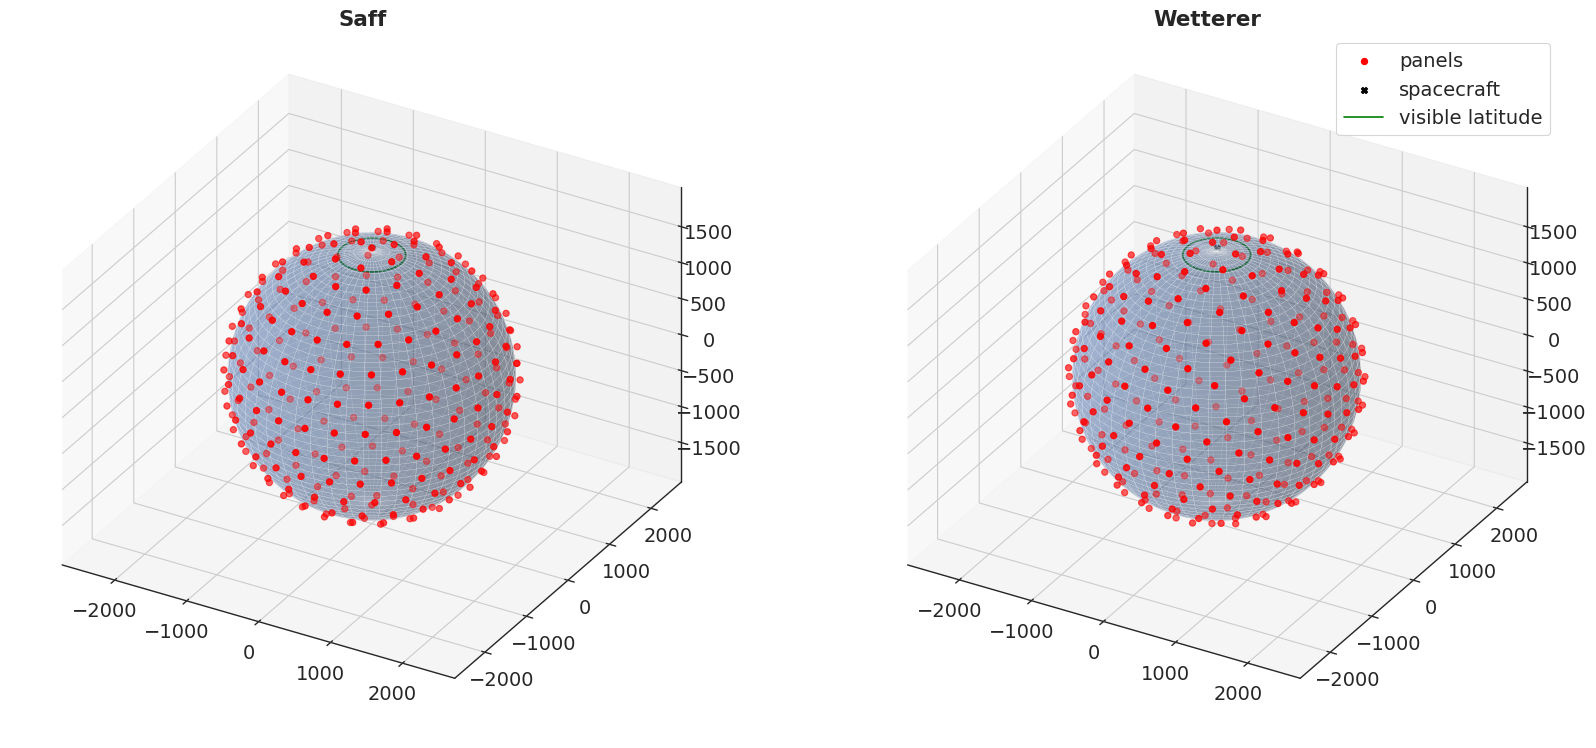

In [8]:
def plot_statically_paneled_sphere():
    h = 50
    altitude = h + moon_polar_radius

    def _do_plot(ax, generate_fn):
        azimuths, polars = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]

        ax.plot_surface(*spher2cart(moon_polar_radius, polars, azimuths), alpha=0.3, linewidth=0.1)
        
        panels = generate_fn(290)
        ax.scatter(*spher2cart(altitude, *panels), c="red", label="panels")
        
        cap_polar = calculate_cap_polar_angle(h)
        ax.scatter(0, 0, altitude, marker="X", c="black", label="spacecraft")
        ax.plot(*spher2cart(moon_polar_radius, cap_polar, np.linspace(0, 2*np.pi, 50)), c="green", label="visible latitude")
        
        ax.set_aspect("equal")
    
    fig, (ax_saff, ax_wetterer) = plt.subplots(1, 2, figsize=[20, 10],
                                    subplot_kw={"projection": "3d", "proj_type": "ortho"})

    _do_plot(ax_saff, generate_panels_saff)
    _do_plot(ax_wetterer, generate_panels_wetterer)

    ax_saff.set_title("Saff")
    ax_wetterer.set_title("Wetterer")
    
    plt.legend()
    
plot_statically_paneled_sphere()

In [9]:
def calculate_required_N(n, cap_polar_angle):
    cap_area = 2 * np.pi * moon_polar_radius**2 * (1 - np.cos(cap_polar_angle))
    sphere_area = 4 * np.pi * moon_polar_radius**2
    N = n / cap_area * sphere_area
    return np.ceil(N)

calculate_required_N(40, calculate_cap_polar_angle(38))

3735.0

In LRO's orbit, ~2858 panels would be necessary that at least 40 panels are visible at all times, as recommended by Wetterer 2014.

In [10]:
def calculate_visible_n(N, cap_polar_angle):
    cap_area = 2 * np.pi * moon_polar_radius**2 * (1 - np.cos(cap_polar_angle))
    sphere_area = 4 * np.pi * moon_polar_radius**2
    n = N * cap_area / sphere_area
    return np.ceil(n)

calculate_visible_n(2000, calculate_cap_polar_angle(38))

22.0

At LRO's minimum altitude of 38 km, 22 panels are visible when the moon is paneled with 2000 panels.

### Unit test data

In [11]:
def generate_unit_test_data_saff():
    polars, azimuths = generate_panels_saff(10)
    print(",\n".join(map(str, polars)))
    print()
    print(",\n".join(map(str, azimuths)))
    
generate_unit_test_data_saff()

3.141592653589793,
2.4619188346815495,
2.1598272970111707,
1.9106332362490186,
1.6821373411358607,
1.4594553124539327,
1.2309594173407747,
0.9817653565786227,
0.6796738189082441,
0.0

0.0,
1.8112150617748297,
3.180364954435027,
4.387841662284913,
5.53335464780712,
0.39568232614974086,
1.6031590339996273,
2.9723089266598244,
4.783523988434654,
0.0


In [12]:
def generate_unit_test_data_wetterer():
    polars, azimuths = generate_panels_wetterer(10)
    print(",\n".join(map(str, polars)))
    print()
    print(",\n".join(map(str, azimuths)))
    
generate_unit_test_data_wetterer()

2.6905658417935308,
2.34619382340565,
2.0943951023931953,
1.8754889808102941,
1.6709637479564563,
1.4706289056333366,
1.266103672779499,
1.0471975511965974,
0.7953988301841433,
0.4510268117962619

0.0,
2.399963229728653,
4.799926459457306,
0.9167043820063725,
3.3166676117350256,
5.716630841463679,
1.833408764012745,
4.2333719937413985,
0.35014991629046577,
2.750113146019119


## Dynamic paneling

Easiest way to generate Knocke's panels is to pretend target is above North Pole first, then rotate to actual target position.

Naive version that converts to Cartesian, rotates to target position, then converts back to spherical. Is there any way to do this in spherical coordinates?

In [13]:
def generate_panels_knocke(pos, n_panels_per_ring: list[int], r=moon_polar_radius):
    # Initialize with central cap
    polars = [0]
    azimuths = [0]
    areas = []

    n_rings = len(n_panels_per_ring)
    spherical_cap_angle = np.arccos(r / np.linalg.norm(pos))
    angular_resolution_polar = spherical_cap_angle / (n_rings + 1)

    area_central_cap = 2 * np.pi * r**2 * (1 - np.cos(angular_resolution_polar))
    areas.append(area_central_cap)

    for polar, n_panels_current_ring in zip(
        np.arange(angular_resolution_polar * 1.5, spherical_cap_angle, angular_resolution_polar),
        n_panels_per_ring):

        angular_resolution_azimuth = 2 * np.pi / n_panels_current_ring
        for azimuth in np.arange(0, 2 * np.pi, angular_resolution_azimuth):
            polars.append(polar)
            azimuths.append(azimuth)

            area_sector = 2 * r**2 * angular_resolution_azimuth * np.sin(angular_resolution_polar / 2) * np.sin(polar)
            areas.append(area_sector)
    
    rotation = align_vectors(np.array([0, 0, 1]), pos)
    polars_rotated = []
    azimuths_rotated = []

    for polar, azimuth in zip(polars, azimuths):
        coords_cartesian = spher2cart(r, polar, azimuth)
        # coords_cartesian_target_centric = rotation.apply(coords_cartesian)
        coords_cartesian_target_centric = rotation @ coords_cartesian
        coords_spherical_target_centric = cart2spher(*coords_cartesian_target_centric)
        polars_rotated.append(coords_spherical_target_centric[1] % (np.pi))
        azimuths_rotated.append(coords_spherical_target_centric[2] % (2 * np.pi))
    
    return polars_rotated, azimuths_rotated, areas

generate_panels_knocke(np.array([0, 0, moon_polar_radius + 50]), [3])

([0.0, 0.17788485270612345, 0.17788485270612345, 0.17788485270612345],
 [0.0, 0.0, 2.0943951023931953, 4.18879020478639],
 [132995.1171146707,
  132372.38563055103,
  132372.38563055103,
  132372.38563055103])

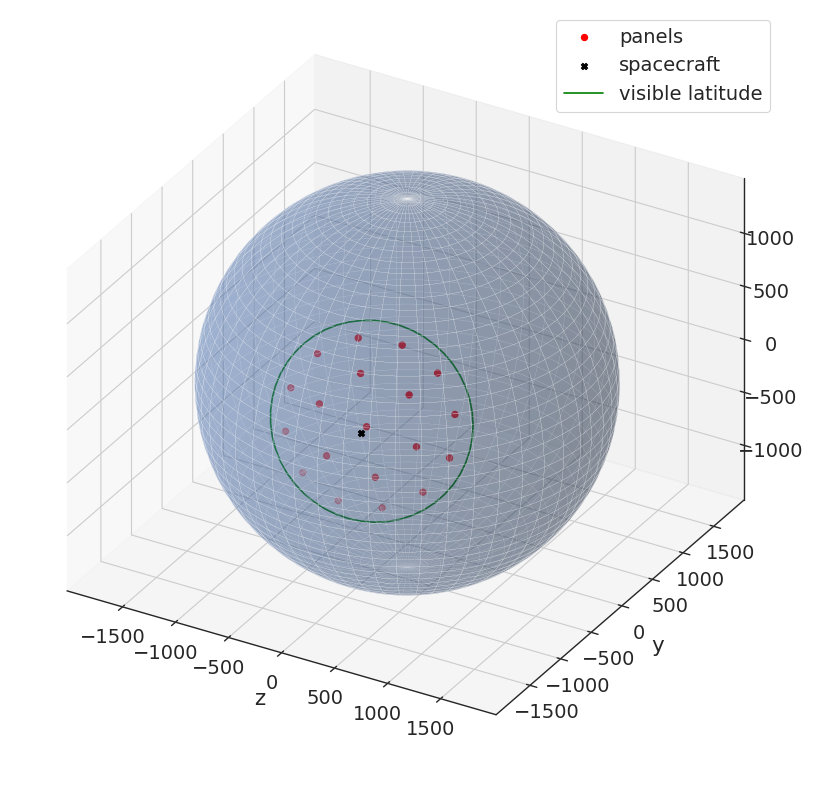

In [14]:
def plot_dynamically_paneled_sphere():
    h = 250
    pos = np.array([1, -3, 1])

    altitude = moon_polar_radius + h
    pos = pos / np.linalg.norm(pos) * altitude

    fig, ax = plt.subplots(1, 1, figsize=[20, 10],
                                    subplot_kw={"projection": "3d", "proj_type": "ortho"})

    azimuths, polars = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]

    ax.plot_surface(*spher2cart(moon_polar_radius, polars, azimuths), alpha=0.3, linewidth=0.1)
    
    panels = generate_panels_knocke(pos, [6, 12])
    ax.scatter(*spher2cart(moon_polar_radius, *panels[:-1]), c="red", label="panels")
    
    cap_polar = calculate_cap_polar_angle(h)
    ax.scatter(*pos, marker="X", c="black", label="spacecraft")

    # Draw circle of visible region
    rotation = align_vectors(np.array([0, 0, 1]), pos)
    visible_region = np.zeros((50, 3))

    for i, azimuth in enumerate(np.linspace(0, 2*np.pi, 50)):
        visible_region[i, :] = rotation @ np.array(spher2cart(moon_polar_radius, cap_polar, azimuth))
    ax.plot(*visible_region.T, c="green", label="visible latitude")
    
    ax.set_aspect("equal")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlabel("z")
    
    plt.legend()
    
plot_dynamically_paneled_sphere()

### Unit test data

In [15]:
def generate_unit_test_data_knocke():
    distance = 1736e3 + 50e3
    direction = np.array([1, 4, -2])
    pos = direction / np.linalg.norm(direction) * distance

    print(pos)
    print()

    polars, azimuths, areas = generate_panels_knocke(pos, [6, 11], r=1736e3)
    print(",\n".join(map(str, polars)))
    print()
    print(",\n".join(map(str, azimuths)))
    print()
    print(",\n".join(map(str, areas)))

with np.printoptions(precision=30): 
    generate_unit_test_data_knocke()

[ 389737.1519614824 1558948.6078459297 -779474.3039229648]

2.0224297678744287,
2.047877556334641,
2.136150520476182,
2.105861502237243,
1.9905687343731608,
1.9081869714047708,
1.9356833964512896,
2.0609813958629832,
2.1611485204045766,
2.2163640745411137,
2.2037113459078386,
2.1287065837117263,
2.0209606333816557,
1.9161553515699112,
1.8445432907351633,
1.825732091599134,
1.8648422421398858,
1.951226570528701

1.3258176636680326,
1.1962484139825238,
1.2872726659199039,
1.421566020343163,
1.4518429848343788,
1.3603079148388213,
1.2376672636524402,
1.1081744372204867,
1.1631836508258644,
1.2809632745094919,
1.4180375866156136,
1.5164475025054232,
1.5454931543149055,
1.5068002183873146,
1.418141127572344,
1.3051176681093595,
1.197514780036697,
1.1241208988411142

59147445289.420876,
29512138145.00732,
29512138145.00732,
29512138145.00732,
29512138145.00732,
29512138145.00732,
29512138145.00732,
26717454531.532776,
26717454531.532776,
26717454531.532776,
26717454531.532776,
26717454531.53